In [1]:
import cpr_gym
import itertools
import gym
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from pandarallel import pandarallel

pandarallel.initialize(use_memory_fs=False)

print(cpr_gym.engine.cpr_lib_version)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
local-v0.4-80-g2d0cff0-dirty


In [2]:
protocol_dict = dict(
    nakamoto=cpr_gym.protocols.nakamoto(),
    tailstorm8constant=cpr_gym.protocols.tailstorm(k=8, reward="constant"),
    tailstorm8discount=cpr_gym.protocols.tailstorm(k=8, reward="discount"),
)


def sparse(episode_len=100, protocol=None, **kwargs):
    env = gym.make(
        "cpr_gym:core-v0",
        proto=protocol_dict[protocol],
        **kwargs,
        max_steps=episode_len,
    )
    env = cpr_gym.wrappers.SparseRewardPerProgressWrapper(env)
    return env


def dense(episode_len=None, protocol=None, **kwargs):
    env = gym.make("cpr_gym:core-v0", proto=protocol_dict[protocol], **kwargs)
    env = cpr_gym.wrappers.DenseRewardPerProgressWrapper(env, episode_len=episode_len)
    return env


env_dict = dict(sparse=sparse, dense=dense)


def run_episode(env, policy=None):
    p = lambda obs: env.policy(obs, policy)
    obs = env.reset()
    acc = 0
    done = False
    while not done:
        obs, reward, done, info = env.step(p(obs))
        acc += reward
    info["episode_reward"] = acc
    return info


def measure(env="sparse", n_episodes=1, policy="honest", **kwargs):
    env = env_dict[env](**kwargs)
    rewards = []
    runtime = []
    for i in range(n_episodes):
        try:
            info = run_episode(env, policy=policy)
            rewards.append(info["episode_reward"] / kwargs["alpha"])
            runtime.append(info["episode_chain_time"])
        except ValueError as e:
            warnings.warn(str(e))
            print(kwargs)
            print(f"policy: {policy}")
            print(e)
    return [np.median(rewards), np.median(runtime)]


alpha = np.linspace(0.1, 1.0, 10)
episode_len = [8, 16, 32, 64, 128]

dfs = []
for protocol in protocol_dict.keys():
    env = env_dict["sparse"](protocol=protocol)
    df = pd.DataFrame(
        itertools.product(
            [protocol], alpha, episode_len, env_dict.keys(), env.policies()
        ),
        columns=["protocol", "alpha", "episode_len", "env", "policy"],
    )
    df["n_episodes"] = [int(np.ceil(8096 / h)) for h in df.episode_len]

    df[["reward", "runtime"]] = df.parallel_apply(
        lambda x: pd.Series(measure(**x)),
        axis=1,
    )
    dfs.append(df)
d = pd.concat(dfs, ignore_index=True)
d

/home/patrik/devel/cpr/python/gym/cpr_gym/wrappers.py:97: UserWarning: observed too much progress: 9.0/8
  warnings.warn(f"observed too much progress: {got}/{want}")
/home/patrik/devel/cpr/python/gym/cpr_gym/wrappers.py:97: UserWarning: observed too much progress: 9.0/8
  warnings.warn(f"observed too much progress: {got}/{want}")
/home/patrik/devel/cpr/python/gym/cpr_gym/wrappers.py:97: UserWarning: observed too much progress: 9.0/8
  warnings.warn(f"observed too much progress: {got}/{want}")
/home/patrik/devel/cpr/python/gym/cpr_gym/wrappers.py:97: UserWarning: observed too much progress: 9.0/8
  warnings.warn(f"observed too much progress: {got}/{want}")
/home/patrik/devel/cpr/python/gym/cpr_gym/wrappers.py:97: UserWarning: observed too much progress: 9.0/8
  warnings.warn(f"observed too much progress: {got}/{want}")


,protocol,alpha,episode_len,env,policy,n_episodes,reward,runtime
0,nakamoto,0.1,8,sparse,sapirshtein-2016-sm1,1012,0.000000,8.469495
1,nakamoto,0.1,8,sparse,eyal-sirer-2014,1012,0.000000,8.258305
2,nakamoto,0.1,8,sparse,simple,1012,0.000000,8.437763
3,nakamoto,0.1,8,sparse,honest,1012,1.111111,8.636492
4,nakamoto,0.1,8,dense,sapirshtein-2016-sm1,1012,0.000000,8.189152
...,...,...,...,...,...,...,...,...
1195,tailstorm8discount,1.0,128,sparse,honest,64,1.000000,114.008671
1196,tailstorm8discount,1.0,128,dense,override-catchup,64,1.000000,127.693535
1197,tailstorm8discount,1.0,128,dense,override-block,64,1.000000,129.330093
1198,tailstorm8discount,1.0,128,dense,release-block,64,1.000000,129.179828


Compare the sparse versus dense reward. They should be the same in all scenarios. The following plot confirms this.

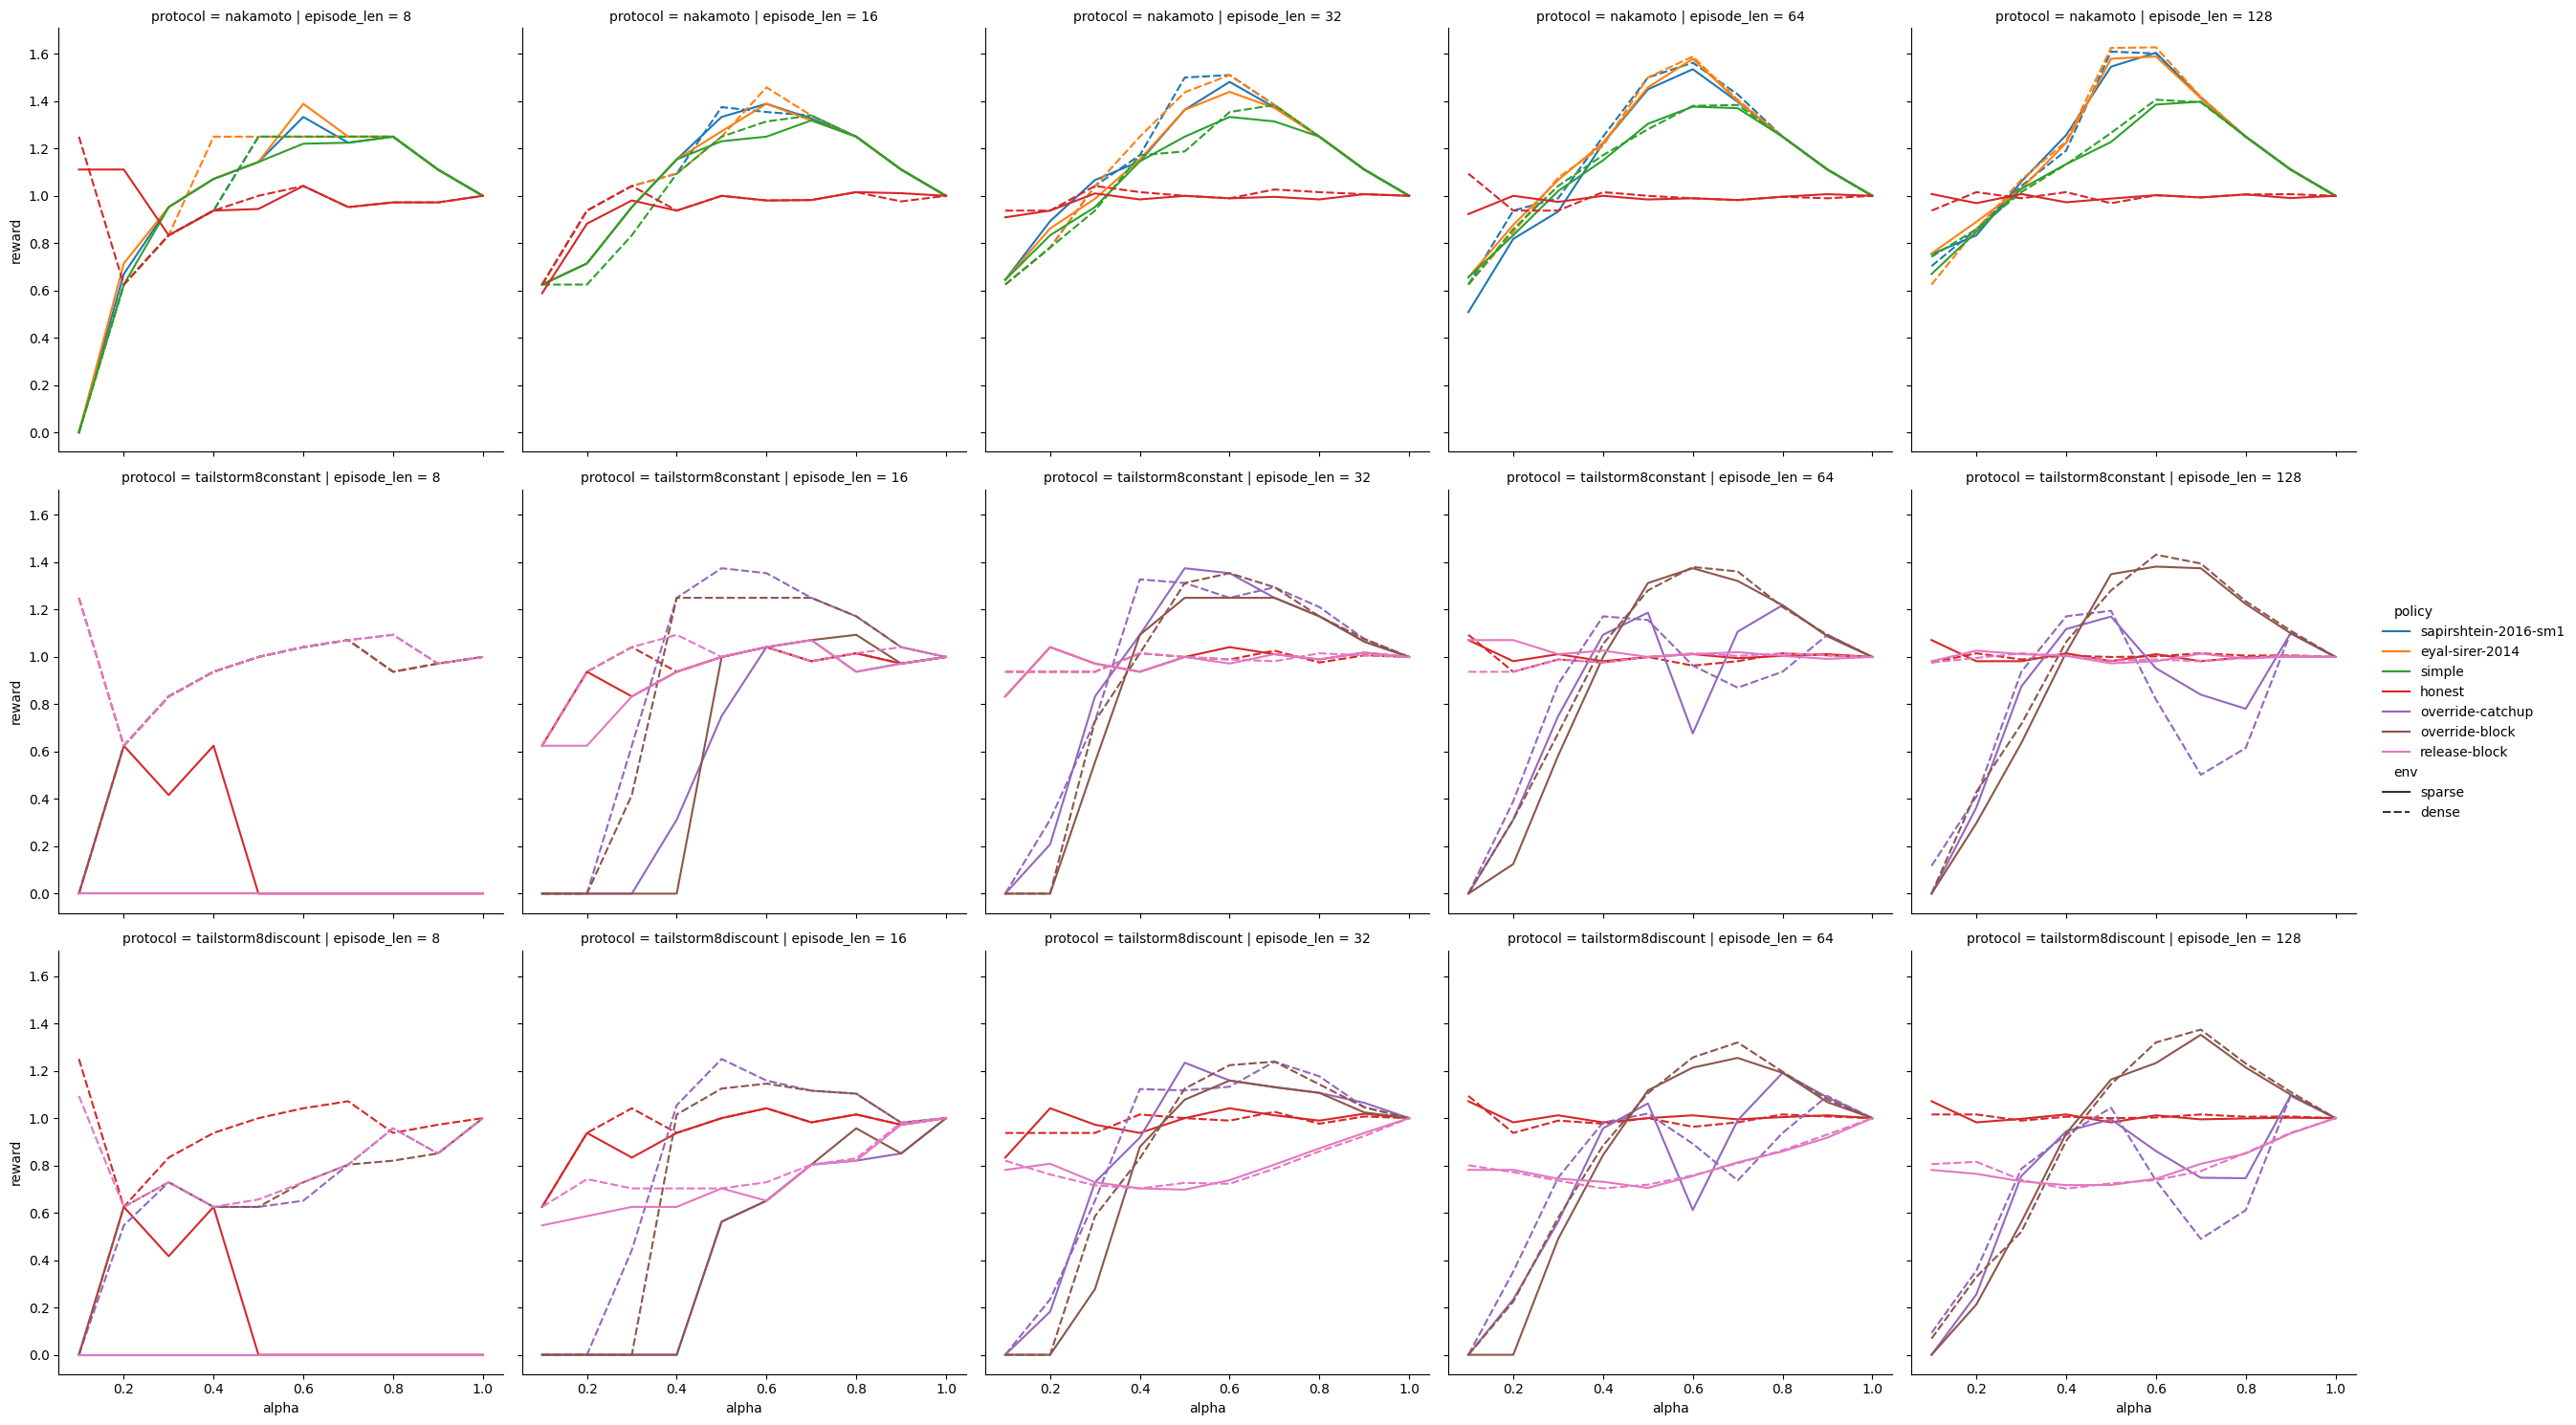

In [3]:
sns.relplot(
    data=d,
    kind="line",
    x="alpha",
    y="reward",
    hue="policy",
    style="env",
    col="episode_len",
    row="protocol",
)

Compare runtime of sparse versus dense wrapper. Sparse should hit the target `episode_len` because it stops after `episode_len` proofs-of-work puzzles. Dense stops at a given chain progress, hence it should run longer for any strategy/alpha combination that causes withholding. The folliwing plot confirms this.

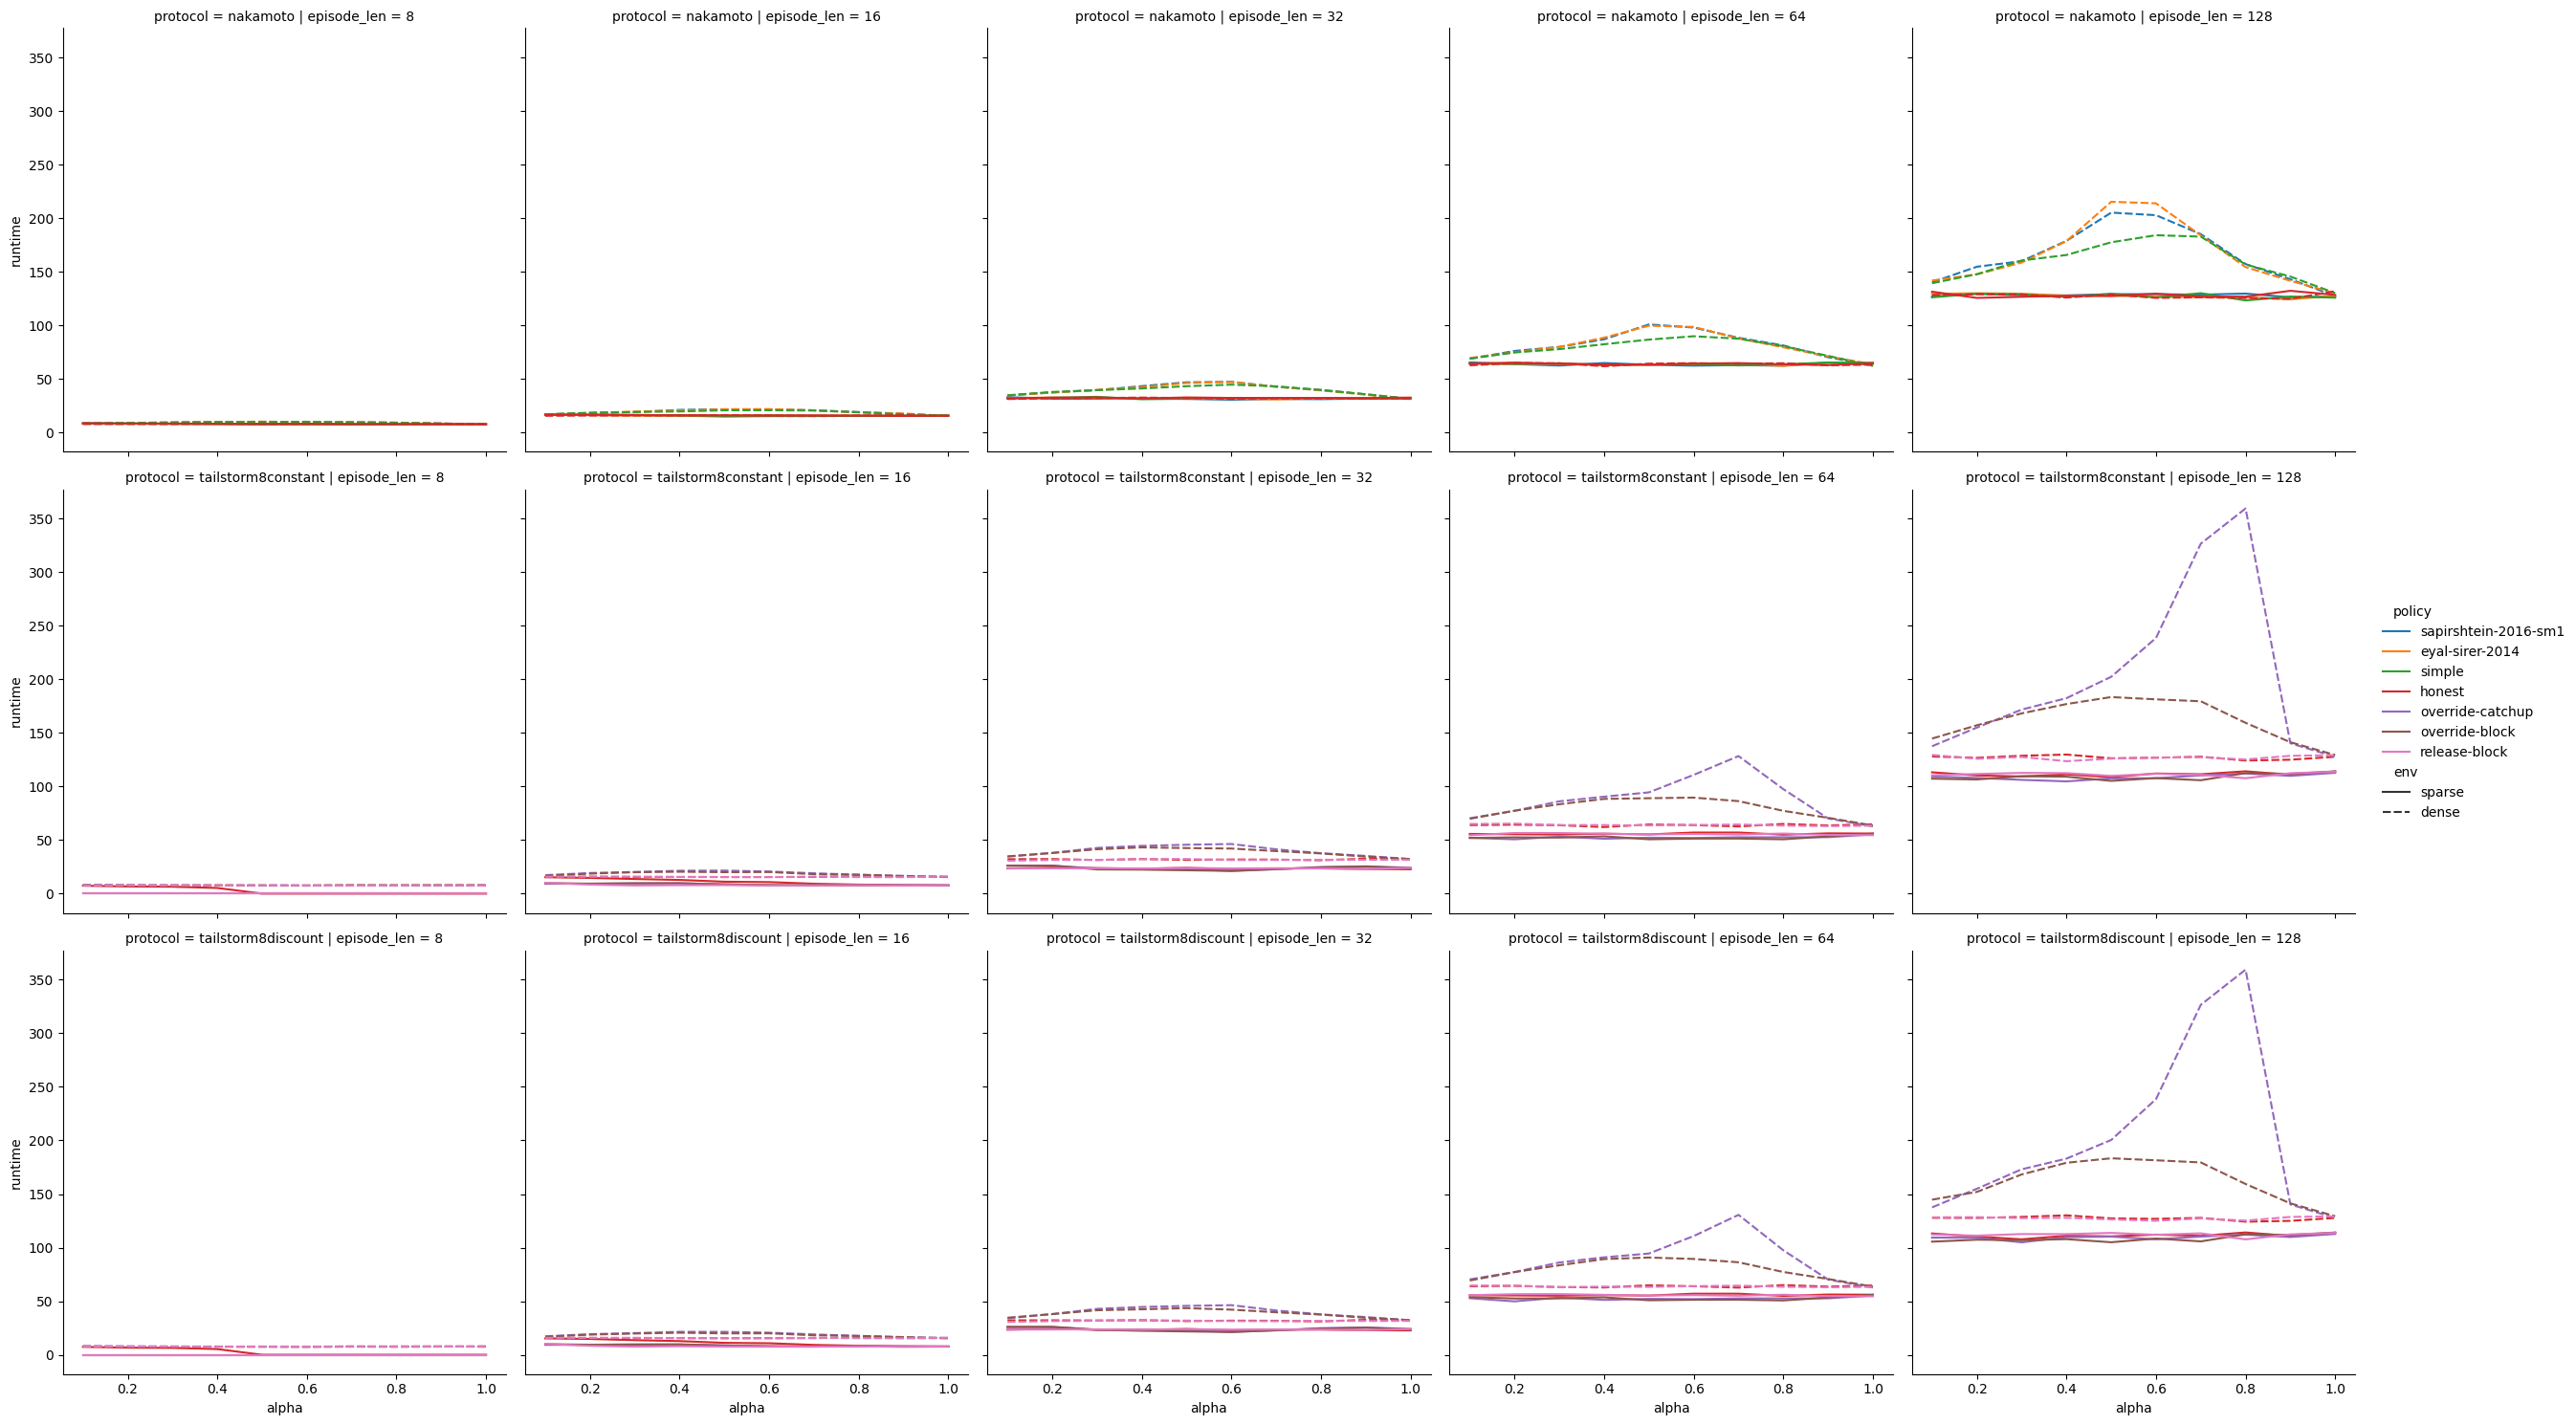

In [4]:
g = sns.relplot(
    data=d,
    kind="line",
    x="alpha",
    y="runtime",
    hue="policy",
    style="env",
    col="episode_len",
    row="protocol",
)

We now compare the two reward schemes `discount` and `constant` for Tailstorm. We do this only for the dense reward wrapper since the sparse one is equivalent (see above). We expect that `discount` has a negative effect on the efficiency of some attack strategies. The plot confirms this.

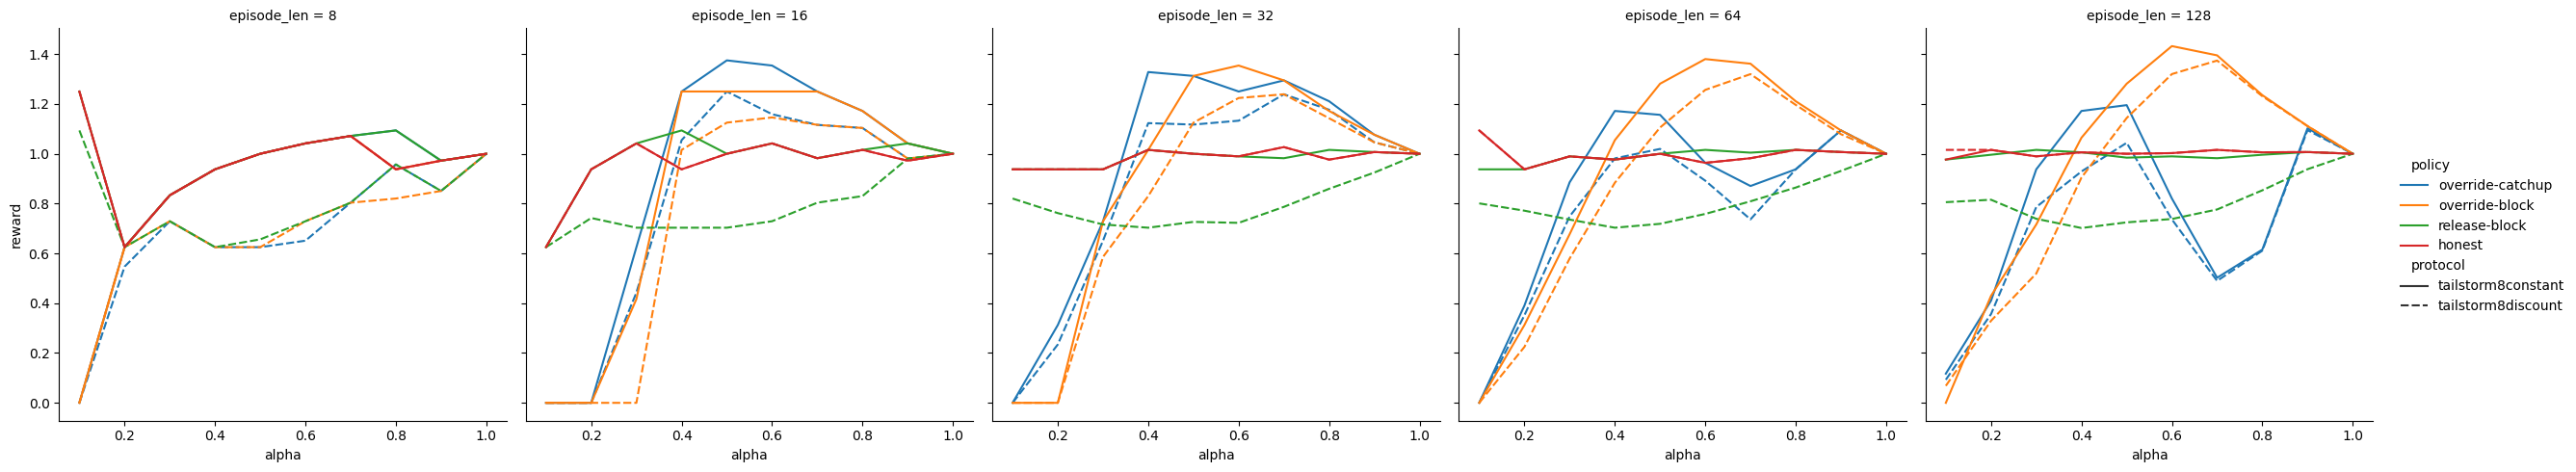

In [5]:
s = d[d.protocol != "nakamoto"]
s = s[s.env == "dense"]
g = sns.relplot(
    data=s,
    kind="line",
    x="alpha",
    y="reward",
    hue="policy",
    style="protocol",
    col="episode_len",
)